# Imports

In [2]:
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# Downloading state data

In [3]:
graph_path = "./wisconsin.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Chain stuff

In [7]:
graph.nodes[0]

{'boundary_node': False,
 'area': 4504716.392765882,
 'GEOID10': '55001002750001',
 'OBJECTID': 1,
 'NAME': 'Adams - C 1',
 'ASM': 41,
 'SEN': 14,
 'CON': 3,
 'CNTY_NAME': 'Adams',
 'PERSONS': 661,
 'WHITE': 620,
 'BLACK': 17,
 'HISPANIC': 15,
 'ASIAN': 1,
 'AMINDIAN': 5,
 'PISLAND': 0,
 'OTHER': 0,
 'OTHERMLT': 3,
 'PERSONS18': 484,
 'WHITE18': 463,
 'BLACK18': 9,
 'HISPANIC18': 8,
 'ASIAN18': 1,
 'AMINDIAN18': 3,
 'PISLAND18': 0,
 'OTHER18': 0,
 'OTHERMLT18': 0,
 'CDATOT16': 183,
 'CDADEM16': 0,
 'CDADEM216': 0,
 'CDAREP16': 0,
 'CDAIND16': 180,
 'CDASCT16': 3,
 'PRETOT16': 258,
 'PREDEM16': 110,
 'PREREP16': 127,
 'PREGRN16': 3,
 'PRELIB16': 6,
 'PRECON16': 3,
 'PREIND16': 1,
 'PREIND216': 1,
 'PREIND316': 0,
 'PREIND416': 2,
 'PREIND516': 0,
 'PREIND616': 0,
 'PREIND716': 0,
 'PREIND816': 0,
 'PREIND916': 0,
 'PREIND1016': 0,
 'PREIND1116': 0,
 'PRESCT16': 5,
 'USHTOT16': 164,
 'USHDEM16': 162,
 'USHDEM216': 0,
 'USHREP16': 0,
 'USHGRN16': 0,
 'USHLIB16': 0,
 'USHIND16': 0,
 'USHSC

In [8]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["PERSONS"]
    
print(pop_count)

5686986


**Getting an error here**

In [16]:
num_dist = 8

# Exercise: Compute exact population from your data.
pop = pop_count

my_updaters = {
    "population": updaters.Tally("PERSONS", alias="population"),
    "cut_edges": cut_edges,
    "SEN16": Election("SEN16", {"democratic":"USSDEM16","republican":"USSREP16"})
}


new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "PERSONS",
                               0.05,
                               1)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

KeyError: 1334

In [35]:
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.05,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [58]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.2),
        compactness_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000,
)

# Pulling data from chain run

In [59]:
%%time

mm = []
pg = []

for step in tqdm_notebook(chain):
    mm.append(mean_median(step["SEN16"]))
    pg.append(partisan_gini(step["SEN16"]))

CPU times: user 44min 59s, sys: 27.2 s, total: 45min 26s
Wall time: 45min 37s


# Visualization

Text(0.5, 1.0, 'Utah Partisan Gini Scores')

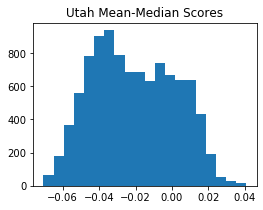

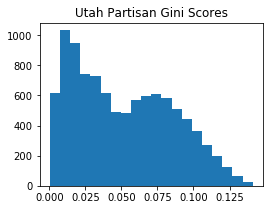

In [64]:
fig, mm_plt = plt.subplots(figsize=(4,3))
fig, pg_plt = plt.subplots(figsize=(4,3))

bins_num = 20

mm_plt.hist(mm, bins=bins_num)
pg_plt.hist(pg, bins=bins_num)


mm_plt.set_title("Utah Mean-Median Scores")
pg_plt.set_title("Utah Partisan Gini Scores")